In [1]:
###
import pandas as pd

pd.set_option("display.max_rows", 101)

from scipy import signal, interpolate

#adding the sys in order to import hypercat and plotting
import sys
sys.path.append('./hypercat/')

#import
import hypercat as hc
import plotting as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pylab as p
%matplotlib inline

In [35]:
#dir
dir_table='/Users/motigomeman/Study/ClumpyImage/Data/Tables/Resolvables/'

#dir of the list of instruments and AGN 
dir_objlist='./examples/'

##Loading hdf file: update the hdf dir based on your dir
hdf_dir='/Users/motigomeman/Study/ClumpyImage/Data/Hypercat/'
hdf_file='hypercat_20170714.hdf5'

##json file
jsonfile='./examples/ngc1068.json'

#file names
B13_T6='Burtscher13_Table6.csv'
telescope_list='Instrument_list.csv'

#AGN list
df_ini=pd.read_csv(dir_objlist+B13_T6)
#telescope/instruments list
df_tel=pd.read_csv(dir_objlist+telescope_list, sep='&', skipinitialspace=True)

### List of AGN
we compile the list of AGN based on the sources who have been observed in VLTI based on **Burtscher et al. (2013)**.

In [36]:
#AGN list
df_ini

Name name_abbrev  LMIR_log  Lbol_log  r_in  r_300K r_half  \
0            I Zw 1        IZw1      44.9      46.2  0.49   124.0   <2.7   
1           NGC 424      NGC424      43.6      44.7  0.09    23.0    1.3   
2          NGC 1068     NGC1068      44.0      45.2  0.15    37.0    1.6   
3          NGC 1365     NGC1365      42.5      43.3  0.02     4.4    0.3   
4   IRAS 05189-2524   IRAS05189      44.6      45.9  0.36    89.0   <3.5   
5        H 0557-385       H0557      44.4      45.6  0.25    63.0   <1.6   
6   IRAS 09149-6206   IRAS09149      44.9      46.3  0.53   132.0   <2.7   
7      MCG-05-23-16   MCG052316      43.5      44.6  0.08    19.0    1.9   
8          Mrk 1239     Mrk1239      44.0      45.2  0.15    38.0    0.8   
9          NGC 3281     NGC3281      43.4      44.4  0.06    15.0   <0.6   
10         NGC 3783     NGC3783      43.7      44.8  0.09    23.0    2.0   
11         NGC 4151     NGC4151      43.0      44.0  0.04     9.4   >1.7   
12           3C 273       3C273      45.7      47.2  1.54   387.0    8.1   
13         NGC 4507     NGC4507      43.7      44.8  0.10    25.0    3.0   
14         NGC 4593     NGC4593      43.1      44.1  0.04    11.0    NaN   
15       ESO 323-77      ESO323      43.7      44.8  0.10    24.0    1.1   
16      Centaurus A        CenA      41.8      42.6  0.01     1.8  <0.05   
17  IRAS 13349+2438   IRAS13349      45.5      47.0  1.22   305.0   <6.2   
18        IC 4329 A     IC4329A      44.2      45.4  0.19    47.0   <0.8   
19         Circinus    Circinus      42.7      43.6  0.03     6.4    0.8   
20         NGC 5506     NGC5506      43.4      44.4  0.06    16.0   <0.4   
21         NGC 5995     NGC5995      44.1      45.2  0.16    50.0   <2.5   
22         NGC 7469     NGC7469      43.9      45.0  0.12    30.0    4.0   

    Distance  
0      222.0  
1       44.7  
2       14.4  
3       18.1  
4      167.0  
5      135.0  
6      222.0  
7       38.8  
8       84.5  
9       47.6  
10      43.8  
11      16.9  
12     546.0  
13      51.7  
14      41.2  
15      64.2  
16       3.8  
17     393.0  
18      68.3  
19       4.2  
20      28.7  
21     102.0  
22      60.9

### Telescope Information
About **E-ELT/METIS**, the pixel scale is defined by the Nyquest sampling at 3 and 8 um.  
see https://www.eso.org/public/teles-instr/elt/elt-instr/metis/

About **TMT/MICHI**, the pixel scale is defined by 11.9 mas at blue-MICHI, and 27.5 mas at red-MICHI.

About **GMT/NIRMOS**, the pixel scale is in fluctuation in the reference. Here we define the larger pixel scale of 67 mas.  
see https://www.gmto.org/SPIE_2012/Fabricant_NIRMOS_SPIE2012-1.pdf with pixel scale of 0.049”/pix  
see https://www.gmto.org/Resources/GMT-ID-01477-Section_13.5_NIRMOS_.pdf with pixel scale of 0.067"/pix

About **GMT MIR instrument**, the instrument concept of **MIISE** is changed into **GMT/TIGER**, and even TIGER is also (probably) removed from the candidate list of instruments. As of now we are not able to find any MIR instruments from the GMT instrument list.  
see https://www.gmto.org/resources/#science-instruments  
Therefore, here I calculate the pixel scale at each band (L, M, and N) of GMT based on the Nyquist sampling at aech wavelength.

In [37]:
#telescope/instrument list
#df_tel.head(10)
df_tel

Telescope  Diameter  Instrument  Wavelength  Resol  pixscaleDetector
0       ALMA       NaN      Band3      3000.00  0.075               NaN
1        NaN       NaN      Band4      2000.00  0.050               NaN
2        NaN       NaN     Band5       1100.00  0.030               NaN
3        NaN       NaN     Band6       1000.00  0.034               NaN
4        NaN       NaN     Band7        700.00  0.060               NaN
5        NaN       NaN     Band8        450.00  0.040               NaN
6        NaN       NaN     Band9        350.00  0.030               NaN
7      E-ELT      39.0       METIS        3.45  0.022               8.0
8        NaN       NaN         NaN        4.75  0.031               8.0
9        NaN       NaN         NaN        8.70  0.056              21.2
10       NaN       NaN         NaN       10.30  0.066              21.2
11       NaN       NaN         NaN       11.60  0.075              21.2
12      JWST       6.5     NIRCam         2.20  0.085              31.0
13       NaN       NaN         NaN        3.50  0.136              63.0
14       NaN       NaN         NaN        4.80  0.186              63.0
15       NaN       NaN       MIRI         5.00  0.194             110.0
16       NaN       NaN         NaN        8.70  0.337             110.0
17       NaN       NaN         NaN       10.30  0.399             110.0
18       NaN       NaN         NaN       11.60  0.449             110.0
19       NaN       NaN         NaN       15.00  0.581             110.0
20       NaN       NaN         NaN       20.00  0.774             110.0
21       NaN       NaN         NaN       25.00  0.968             110.0
22       GMT      24.5     NIRMOS         1.60  0.016              67.0
23       NaN       NaN         NaN        2.20  0.023              67.0
24       NaN       NaN         NaN        3.45  0.035              67.0
25       NaN       NaN         NaN        4.75  0.049              67.0
26       NaN       NaN      MIISE         3.45  0.035              14.8
27       NaN       NaN         NaN        4.75  0.049              20.4
28       NaN       NaN         NaN        8.70  0.089              37.3
29       NaN       NaN         NaN       10.30  0.106              44.1
30       NaN       NaN         NaN       11.60  0.119              49.7
31       TAO       6.5   MIMIZUKU        20.00  0.774             110.0
32       NaN       NaN         NaN       25.00  0.968             110.0
33       NaN       NaN         NaN       30.00  1.161             176.0
34       NaN       NaN         NaN       35.00  1.355             176.0
35       TMT      30.0       IRIS         2.20  0.018               4.0
36       NaN       NaN      MICHI         3.45  0.029              11.9
37       NaN       NaN         NaN        4.75  0.040              11.9
38       NaN       NaN         NaN        8.70  0.073              27.5
39       NaN       NaN         NaN       10.30  0.086              27.5
40       NaN       NaN         NaN       11.60  0.097              27.5
41      VLTI     200.0    MATISSE         3.50  0.004               NaN
42       NaN       NaN         NaN        4.80  0.006               NaN
43       NaN       NaN         NaN        8.70  0.011               NaN
44       NaN       NaN         NaN       10.30  0.013               NaN
45       NaN       NaN         NaN       11.60  0.015               NaN
46       NaN       NaN         NaN       12.50  0.016               NaN
47       NaN       NaN  AMBER/VSI         2.20  0.003               NaN

In [38]:
############Revision of the telescope/instrument list

#Calculating the Resolution with Radian
df_tel.loc[:,'Resol_rad']=df_tel['Resol']*np.pi/(3600*180)
#filling the nan with the forward filling
df_tel.loc[:,'Telescope']=df_tel['Telescope'].fillna(method='ffill')
df_tel.loc[:,'Diameter']=df_tel['Diameter'].fillna(method='ffill')
df_tel.loc[:,'Instrument']=df_tel['Instrument'].fillna(method='ffill')
#Adding the information of Interferometry
criteria_interfero=df_tel['Telescope'].isin(['ALMA']) | (df_tel['Telescope']=='VLTI')
df_tel.loc[:, 'Interferometry']=(df_tel['Telescope']*0+'Y').where(criteria_interfero, 'N')


In [39]:
#checking the revision of the instrument list
df_tel.head(10)
df_tel

Telescope  Diameter  Instrument  Wavelength  Resol  pixscaleDetector  \
0       ALMA       NaN      Band3      3000.00  0.075               NaN   
1       ALMA       NaN      Band4      2000.00  0.050               NaN   
2       ALMA       NaN     Band5       1100.00  0.030               NaN   
3       ALMA       NaN     Band6       1000.00  0.034               NaN   
4       ALMA       NaN     Band7        700.00  0.060               NaN   
5       ALMA       NaN     Band8        450.00  0.040               NaN   
6       ALMA       NaN     Band9        350.00  0.030               NaN   
7      E-ELT      39.0       METIS        3.45  0.022               8.0   
8      E-ELT      39.0       METIS        4.75  0.031               8.0   
9      E-ELT      39.0       METIS        8.70  0.056              21.2   
10     E-ELT      39.0       METIS       10.30  0.066              21.2   
11     E-ELT      39.0       METIS       11.60  0.075              21.2   
12      JWST       6.5     NIRCam         2.20  0.085              31.0   
13      JWST       6.5     NIRCam         3.50  0.136              63.0   
14      JWST       6.5     NIRCam         4.80  0.186              63.0   
15      JWST       6.5       MIRI         5.00  0.194             110.0   
16      JWST       6.5       MIRI         8.70  0.337             110.0   
17      JWST       6.5       MIRI        10.30  0.399             110.0   
18      JWST       6.5       MIRI        11.60  0.449             110.0   
19      JWST       6.5       MIRI        15.00  0.581             110.0   
20      JWST       6.5       MIRI        20.00  0.774             110.0   
21      JWST       6.5       MIRI        25.00  0.968             110.0   
22       GMT      24.5     NIRMOS         1.60  0.016              67.0   
23       GMT      24.5     NIRMOS         2.20  0.023              67.0   
24       GMT      24.5     NIRMOS         3.45  0.035              67.0   
25       GMT      24.5     NIRMOS         4.75  0.049              67.0   
26       GMT      24.5      MIISE         3.45  0.035              14.8   
27       GMT      24.5      MIISE         4.75  0.049              20.4   
28       GMT      24.5      MIISE         8.70  0.089              37.3   
29       GMT      24.5      MIISE        10.30  0.106              44.1   
30       GMT      24.5      MIISE        11.60  0.119              49.7   
31       TAO       6.5   MIMIZUKU        20.00  0.774             110.0   
32       TAO       6.5   MIMIZUKU        25.00  0.968             110.0   
33       TAO       6.5   MIMIZUKU        30.00  1.161             176.0   
34       TAO       6.5   MIMIZUKU        35.00  1.355             176.0   
35       TMT      30.0       IRIS         2.20  0.018               4.0   
36       TMT      30.0      MICHI         3.45  0.029              11.9   
37       TMT      30.0      MICHI         4.75  0.040              11.9   
38       TMT      30.0      MICHI         8.70  0.073              27.5   
39       TMT      30.0      MICHI        10.30  0.086              27.5   
40       TMT      30.0      MICHI        11.60  0.097              27.5   
41      VLTI     200.0    MATISSE         3.50  0.004               NaN   
42      VLTI     200.0    MATISSE         4.80  0.006               NaN   
43      VLTI     200.0    MATISSE         8.70  0.011               NaN   
44      VLTI     200.0    MATISSE        10.30  0.013               NaN   
45      VLTI     200.0    MATISSE        11.60  0.015               NaN   
46      VLTI     200.0    MATISSE        12.50  0.016               NaN   
47      VLTI     200.0  AMBER/VSI         2.20  0.003               NaN   

       Resol_rad Interferometry  
0   3.636103e-07              Y  
1   2.424068e-07              Y  
2   1.454441e-07              Y  
3   1.648367e-07              Y  
4   2.908882e-07              Y  
5   1.939255e-07              Y  
6   1.454441e-07              Y  
7   1.066590e-07              N  
8   1.502922e-07     

In [40]:
##making a new df
df_rt=df_tel.copy()
df_y=df_tel.copy()

In [41]:
#making a list of telescope/instruments vs. resolvability of each AGN
for i in np.arange(len(df_ini)):
    
    #picking up parameters
    distance=df_ini.loc[i:i,'Distance'].values[0]
    r_in=df_ini.loc[i:i, 'r_in'].values[0]
    objname=df_ini.loc[i:i, 'name_abbrev'].values[0]
    
    #Calculation of the Torus radius
    r_torus=(df_tel['Resol_rad']*distance*1e6*0.5).round(3)
    
    #Calculation of Ymin
    Ymin=(r_torus/r_in).round(3)
    
    #adding the info of resolvability based on Ymin (<20)
    df_y.loc[:,objname]=Ymin.where(Ymin<20.0, np.nan)
    #adding the info of resolvability based on r_torus (<5 pc)
    df_rt.loc[:,objname]=r_torus.where(r_torus<5.0, np.nan)
    
    #adding the criteria: r_torus < 5.0 pc & Ymin < 20.0
    criteria=(Ymin<20.0) & (r_torus<5.0)
    df_tel.loc[:, objname+'_Yval']=Ymin.where(criteria, np.nan)
    df_tel.loc[:, objname+'_rt']=r_torus.where(criteria, np.nan)
    

## Resolvability

Our resolvable criteria is  
**1. r_torus < 5pc**  
**2. Ymin<20**  
Let's show the result based on r_torus < 5pc or  Ymin<20

### 1. r_torus < 5pc
We show the result with nan for the sources who are not able to resolve 5 pm scale.

In [52]:
#torus < 5 pc 
df_rt.style.highlight_null()

### 2. Ymin < 20
we show the result with nan for the sources who are not able to resolve Y=20.

In [53]:
#Y<20
df_y.style.highlight_null()

In [54]:
#Y<20 & r_torus < 5 pc
df_tel.style.highlight_null()

In [55]:
#########List of criterion for picking up the resolvability information

#only single dish
criteria_Single=(df_tel['Interferometry']=='N')

#only single dish and MIR band w/ 5-30um
criteria_MIRandSingle= (df_tel['Wavelength'].between(5.0,30.0)) & (df_tel['Interferometry']=='N')

#only single dish and NIR-MIR band with 1.0-30um
criteria_NandMIRandSingle= (df_tel['Wavelength'].between(1.0,30.0)) & (df_tel['Interferometry']=='N')


In [56]:
#Showing the table with different criteria

#single dish
df_tel[criteria_Single].style.highlight_null()

#MIR and single dish
#df_tel[criteria_MIRandSingle].style.highlight_null()

#N-MIR and single dish
#df_tel[criteria_MIRandSingle].style.highlight_null()

Our resolvable criteria is  
**1. r_torus < 5pc**  
**2. Ymin<20**

The result suggests VLTI MATISSE and VLTI AMBER will resolve all the sources at 3.5um and 2.2 um.  
Most sources will be resolvable at MATISSE 4.8um

For the MIR single dish, **NGC 1068** and **Circinus** could be resolvable.

**NGC1068** is resolvable at 

In [58]:
df_tel[criteria_Single & df_tel['NGC1068_Yval'].notnull()][['Telescope', 'Instrument', 'Wavelength', 'Resol', 'NGC1068_Yval','NGC1068_rt']]

Telescope Instrument  Wavelength  Resol  NGC1068_Yval  NGC1068_rt
7      E-ELT      METIS        3.45  0.022         5.120       0.768
8      E-ELT      METIS        4.75  0.031         7.213       1.082
9      E-ELT      METIS        8.70  0.056        13.033       1.955
10     E-ELT      METIS       10.30  0.066        15.360       2.304
11     E-ELT      METIS       11.60  0.075        17.453       2.618
12      JWST    NIRCam         2.20  0.085        19.780       2.967
22       GMT    NIRMOS         1.60  0.016         3.727       0.559
23       GMT    NIRMOS         2.20  0.023         5.353       0.803
24       GMT    NIRMOS         3.45  0.035         8.147       1.222
25       GMT    NIRMOS         4.75  0.049        11.400       1.710
26       GMT     MIISE         3.45  0.035         8.147       1.222
27       GMT     MIISE         4.75  0.049        11.400       1.710
35       TMT      IRIS         2.20  0.018         4.187       0.628
36       TMT     MICHI         3.45  0.029         6.747       1.012
37       TMT     MICHI         4.75  0.040         9.307       1.396
38       TMT     MICHI         8.70  0.073        16.987       2.548

**Circinus** is resolvable at 

In [59]:
df_tel[criteria_NandMIRandSingle & df_tel['Circinus_Yval'].notnull()][['Telescope', 'Instrument', 'Wavelength', 'Resol', 'Circinus_Yval','Circinus_rt']]

Telescope Instrument  Wavelength  Resol  Circinus_Yval  Circinus_rt
7      E-ELT      METIS        3.45  0.022          7.467        0.224
8      E-ELT      METIS        4.75  0.031         10.533        0.316
9      E-ELT      METIS        8.70  0.056         19.000        0.570
22       GMT    NIRMOS         1.60  0.016          5.433        0.163
23       GMT    NIRMOS         2.20  0.023          7.800        0.234
24       GMT    NIRMOS         3.45  0.035         11.867        0.356
25       GMT    NIRMOS         4.75  0.049         16.633        0.499
26       GMT     MIISE         3.45  0.035         11.867        0.356
27       GMT     MIISE         4.75  0.049         16.633        0.499
35       TMT      IRIS         2.20  0.018          6.100        0.183
36       TMT     MICHI         3.45  0.029          9.833        0.295
37       TMT     MICHI         4.75  0.040         13.567        0.407

## list of resolavility
Here we produce a list of instrument with resolvability into a latex table for each source.

In [61]:
#number of AGN
n=len(df_ini)

#Latex table output script for the list of the resolavable instruments for each AGN source
for i in np.arange(n):
    
    #making a list of initial columns
    list_initial_columns=list(df_tel.columns.values[0:5])
    #making a list of each AGN column
    list_objcolumns=list(df_tel.columns.values[8+2*i:10+2*i])
    
    #making a column of the table
    list_combine=list_initial_columns+list_objcolumns
    
    #y value of each AGN 
    yval=df_tel.columns[8+2*i]
    #obj name of each AGN
    objname=df_tel.columns[8+2*i][0:-5]
    
    #output of the latex table
    df_tel[(df_tel['Interferometry']=='N') & df_tel[yval].notnull()][list_combine].\
    to_csv(dir_table+'resolvable_'+objname+'.tbl', index=None, header=None, sep='&', line_terminator='\\\\\n')
    
    

## Detectability
The next step what we should do is checking the "detectability" for the sources of NGC 1068 and Circinus at MIR bands.  

In [63]:
#Here, I would like to make an image of NGC 1068 for checking the detectability.

#making a cube file obtained from the subcube
cube = hc.ModelCube(hdffile=hdf_dir+hdf_file,hypercube='imgdata',subcube_selection=jsonfile)

Opening HDF5 file: /Users/motigomeman/Study/ClumpyImage/Data/Hypercat/hypercat_20170714.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading objects from file ./examples/ngc1068.json.
Loading hyperslab [shape: (3,2,4,1,5,2,19,221,441)] from hypercube 'imgdata' [shape: (5,11,4,12,5,7,19,221,441)] to RAM (1.66 GB required) ...
Done.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Inspect loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
  sig *    [ 15.000 -  45.000]  (  3)    15.000, 30.000, 45.000
    i *    [ 84.261 -  90.000]  (  2)    84.261, 90.000
    Y *    [  5.000 -  20.000]  (  4)     5.000, 10.000, 15.000, 20.000
    N      [ 12.000 -  12.000]  (  1)    12.000
    q *    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
   tv *    [ 40.000 -  60.000]  (  2)    4

In [64]:
#checking the pixel scale of each detector
df_tel[criteria_Single & df_tel['NGC1068_Yval'].notnull()]['pixscaleDetector'].values

array([  8. ,   8. ,  21.2,  21.2,  21.2,  31. ,  67. ,  67. ,  67. ,
        67. ,  14.8,  20.4,   4. ,  11.9,  11.9,  27.5])

In [65]:
#list of  instrument wavelength and instrument information
waves_instruments=df_tel[criteria_Single & df_tel['NGC1068_Yval'].notnull()]['Wavelength'].values


#NGC 1068
ngc1068=hc.Source(cube, luminosity='2e45 erg/s', distance='14.4 Mpc', name='ngc1068', pa='42 deg')

#params of NGC 1068
sig = 25
i   = 88.0
Y   = 6
#Y = 20
N = 12.0
q   = 2.0
tv  = 49.0
wave_obs = [8.0,9.0,10.0,11.0,12.0]         # micron
fluxdensities_obs = [7.5,7.0,7.2,10.0,13.0]  # photometric data points in Jy  from  AH+11

#You can use
#cube.wave_

#all wavelength of Hypercat
waves=cube.theta[6]

#list of params
vec=(sig,i,N, q,tv, waves)


In [66]:
####Making a function

##Obtaining the wav, SED based on the clumpy param sets
def calc_imageSED(cube, vec):
    
    #cube is the dataset obtained through hc.ModelCube
    #
    #calculation of the SED based on the obtained flux and the estimated torus parameter set
    #vec should contain the dataset of sig, i, N, q, tv, and waves, where waves should be the set of wavelength
    #vec=(sig,i,N, q,tv, waves)
    #
    #input_fnu is the list of the observed fdensity at input_wave
    
    #Obtaining the image dataset
    imagecube=cube.get_image(vec)
    
    #picking up list of wavelengths
    wave=vec[5]
    
    #calc the SED based on
    sed=np.sum(imagecube, axis=(1,2))*wave
    
    return sed
    

In [67]:
def calc_imageSED_norm(cube, vec, obswave, obsfnu):
    
    #cube: clumpy image
    #vec: clumpy fitting parameter set
    #obswave: the list of observed wavelength we know
    #obsfnu: the list of observed fnu we know
    
    #obtaining the waves
    waves=vec[5]
    
    #obtaining the SED
    sed=calc_imageSED(cube, vec)
    
    #obs wave is the unit of um, and obsfnu is the unit of Jy
    
    #obtaining the flux counts at obswave
    f1=interpolate.interp1d(waves, sed)
    flux_counts=f1(obswave)
    
    #calc the ratio
    ratio=obsfnu / flux_counts
    
    #return the normalized flux
    return sed*ratio

In [68]:
def interpolate_fnu_instrument(wavelist, waves, normSED):
    
    #interpolation
    f1=interpolate.interp1d(waves, normSED)
    fluxdensities=f1(wavelist)
    
    return fluxdensities
    

In [69]:
########Actual application

#obtaining the normalized SED
sed_norm=calc_imageSED_norm(vec=vec, cube=cube, obswave=12.0, obsfnu=13.0)

#obtaining the estimated flux density based on the list of the instrument wavelength
fluxdensity_instruments=interpolate_fnu_instrument(wavelist=waves_instruments, waves=waves, normSED=sed_norm)

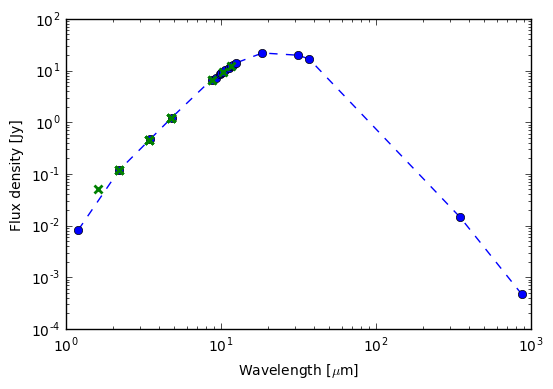

In [70]:
#Plotting of the normalized SED
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'Flux density [Jy]')
plt.loglog(waves, sed_norm, 'o--', label='normalized SED')
plt.loglog(waves_instruments, fluxdensity_instruments , 'x', mew=2, label='interpolated flux density')

In [71]:
#df: instrument wavelength vs. interpolated flux density at each wavelength
df_check=pd.DataFrame(zip(waves_instruments, fluxdensity_instruments), columns=['wave', 'fnu'])

#dividing the dataset based on the instruments
set_IRIS=df_check[df_check['wave']<3.0].values
set_bMICHI=df_check[df_check['wave'].between(3.0,5.0)].values
set_rMICHI=df_check[df_check['wave']>5.0].values

set_IRIS

array([[ 2.2       ,  0.11780269],
       [ 1.6       ,  0.05205915],
       [ 2.2       ,  0.11780269],
       [ 2.2       ,  0.11780269]])

In [72]:
skies_IRIS = [ngc1068((sig,i,Y,q,tv,wave),total_flux_density=str(Fnu)+'Jy') for wave,Fnu in set_IRIS ]
skies_bMICHI = [ngc1068((sig,i,Y,q,tv,wave),total_flux_density=str(Fnu)+'Jy') for wave,Fnu in set_bMICHI ]
skies_rMICHI = [ngc1068((sig,i,Y,q,tv,wave),total_flux_density=str(Fnu)+'Jy') for wave,Fnu in set_rMICHI ]


Rotated image (see self.data) by 42.0 deg in direction 'NE'.


/usr/local/lib/python2.7/site-packages/astropy/units/quantity.py:777: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__ne__(other)


Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.


In [73]:
#telescope information
tmt_rMICHI = hc.Telescope(psfdict={'psf':'model','diameter':30.,'strehl':0.8},name='TMT',pixelscale_detector='27.5 mas')
tmt_bMICHI =hc.Telescope(psfdict={'psf':'model','diameter':30.,'strehl':0.8},name='TMT',pixelscale_detector='11.9 mas')
tmt_IRIS =hc.Telescope(psfdict={'psf':'model','diameter':30.,'strehl':0.8},name='TMT',pixelscale_detector='4.0 mas')

#images w/ psfs
images_IRIS, psfs_IRIS = zip(*[tmt_IRIS(sky) for sky in skies_IRIS])
images_bMICHI, psfs_bMICHI = zip(*[tmt_bMICHI(sky) for sky in skies_bMICHI])
images_rMICHI, psfs_rMICHI = zip(*[tmt_rMICHI(sky) for sky in skies_rMICHI])

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Plotting panel (0,0)
Plotting panel (0,1)
Plotting panel (0,2)
Plotting panel (0,3)
Plotting panel (1,0)
Plotting panel (1,1)
Plotting panel (1,2)
Plotting panel (1,3)


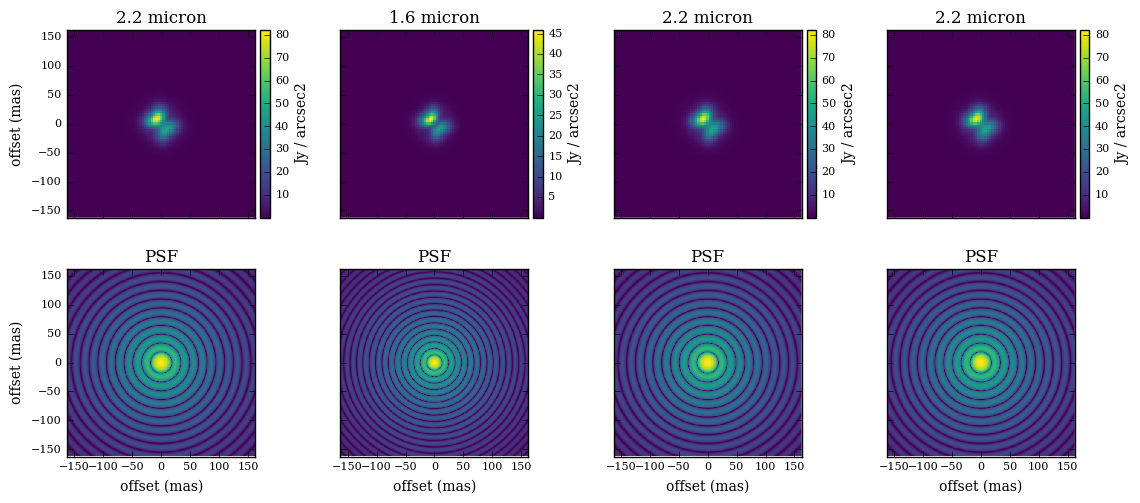

In [74]:
n = len(set_IRIS)

fig, axes = hp.multiplot(images_IRIS+psfs_IRIS,geometry=(2,n),panelsize=3.5,\
                         colorbars=[True]*n,units=['Jy/arcsec^2']*n,\
                         titles=[img.wave for img in images_IRIS]+['PSF']*n,\
                         hspace=-0.4)

Plotting panel (0,0)
Plotting panel (0,1)
Plotting panel (0,2)
Plotting panel (0,3)
Plotting panel (0,4)
Plotting panel (0,5)
Plotting panel (0,6)
Plotting panel (0,7)
Plotting panel (1,0)
Plotting panel (1,1)
Plotting panel (1,2)
Plotting panel (1,3)
Plotting panel (1,4)
Plotting panel (1,5)
Plotting panel (1,6)
Plotting panel (1,7)


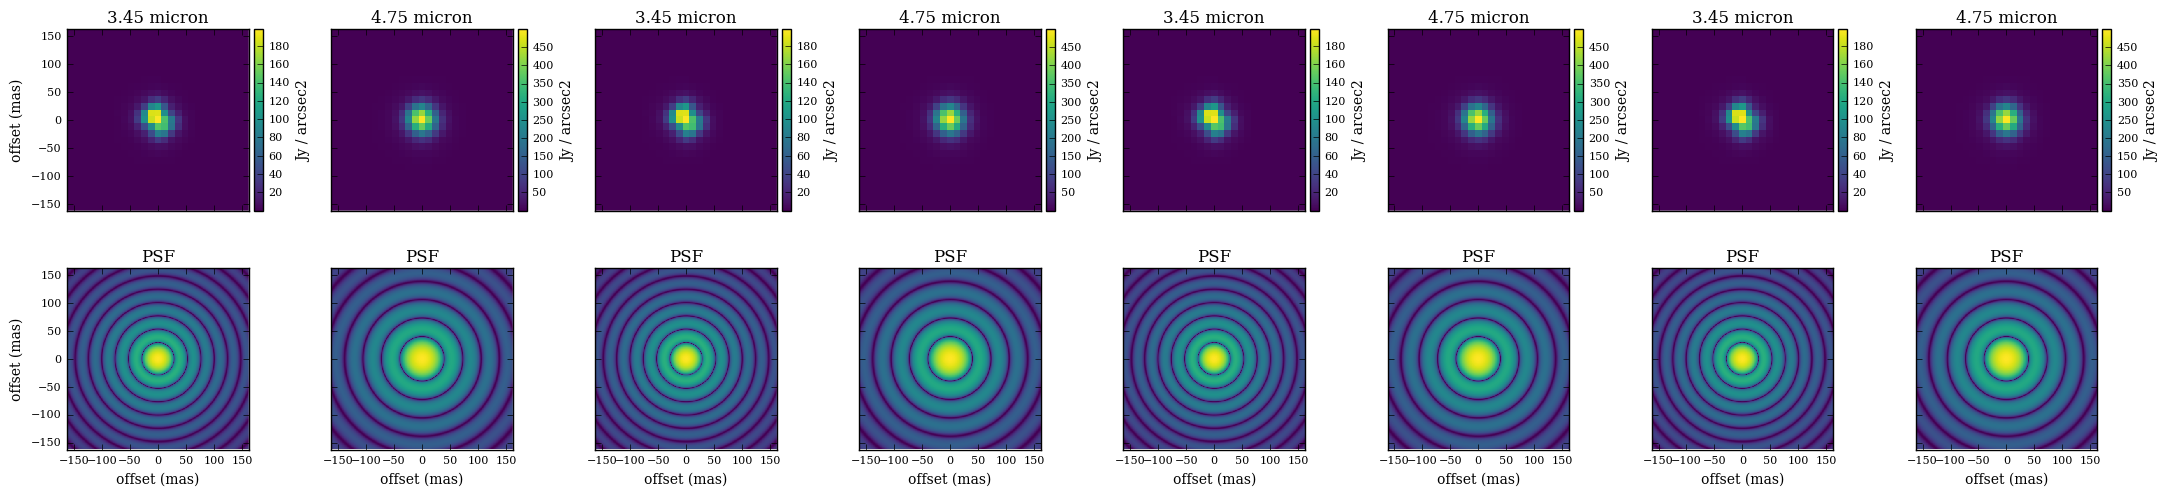

In [75]:
#n = len(waves_instruments)

n = len(set_bMICHI)

fig, axes = hp.multiplot(images_bMICHI+psfs_bMICHI,geometry=(2,n),panelsize=3.5,\
                         colorbars=[True]*n,units=['Jy/arcsec^2']*n,\
                         titles=[img.wave for img in images_bMICHI]+['PSF']*n,\
                         hspace=-0.4)

Plotting panel (0,0)
Plotting panel (0,1)
Plotting panel (0,2)
Plotting panel (0,3)
Plotting panel (1,0)
Plotting panel (1,1)
Plotting panel (1,2)
Plotting panel (1,3)


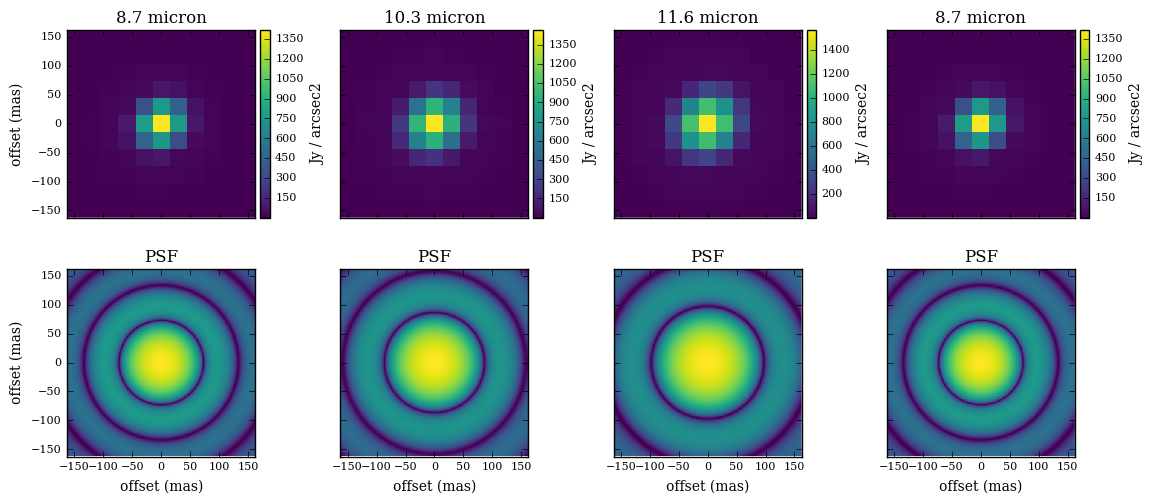

In [76]:
n = len(set_rMICHI)

fig, axes = hp.multiplot(images_rMICHI+psfs_rMICHI,geometry=(2,n),panelsize=3.5,\
                         colorbars=[True]*n,units=['Jy/arcsec^2']*n,\
                         titles=[img.wave for img in images_rMICHI]+['PSF']*n,\
                         hspace=-0.4)